In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from transformers import T5Tokenizer, T5EncoderModel
import os
from os.path import join
import torch
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import pandas as pd
import numpy as np
from tqdm.auto import trange
from contextlib import redirect_stdout
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom
from utils.pixart_utils import state_dict_convert
from utils.pixart_utils import construct_diffuser_pipeline_from_config
from utils.cv2_eval_utils import find_classify_objects, evaluate_parametric_relation, eval_func_factory, scene_info_collection
from utils.cv2_eval_utils import evaluate_pipeline_on_prompts, print_evaluation_summary
from utils.relation_shape_dataset_lib import ShapesDataset

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.i

In [37]:

from circuit_toolkit.plot_utils import saveallforms

### Loading the model

In [18]:
model_run_name = "objrel_T5_DiT_B_pilot" # "objrel_rndembdposemb_DiT_B_pilot" 
# model_run_name = "objrel_T5_DiT_mini_pilot_WDecay" # "objrel_rndembdposemb_DiT_B_pilot" 
# ckpt_name = "epoch_4000_step_160000.pth" # "epoch_4000_step_160000.pth" 
ckpt_name = "epoch_4000_step_160000.pth" # "epoch_4000_step_160000.pth" 
text_encoder_type = "T5" 
suffix = ""

In [19]:
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
# savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"
config = read_config(join(savedir, 'config.py'))
evaldir = join(savedir, "generalization_eval")

In [39]:
eval_df_all_temp = pd.read_csv(join(join(evaldir, f"eval_df_{ckpt_name}_ema_all_templates.csv")))
print(eval_df_all_temp.select_dtypes(include=['number', 'bool']).mean())
eval_df_all_temp.groupby("template").mean(numeric_only=True)

prompt_id                        131.500000
sample_id                         24.000000
overall                            0.414564
overall_loose                      0.568599
shape                              0.896506
color                              0.917749
exist_binding                      0.873438
unique_binding                     0.871738
spatial_relationship               0.414564
spatial_relationship_loose         0.568599
Dx                               -19.160631
Dy                               -20.451529
x1                                56.153732
y1                                52.111308
x2                                75.314362
y2                                72.562837
step_num                      160000.000000
ema                                1.000000
dtype: float64


,prompt_id,sample_id,overall,overall_loose,shape,color,exist_binding,unique_binding,spatial_relationship,spatial_relationship_loose,Dx,Dy,x1,y1,x2,y2,step_num,ema
template,,,,,,,,,,,,,,,,,,
color1_shape1_is_rel_text_color2_shape2,131.5,24.0,0.748609,0.808442,0.857220,0.892316,0.821119,0.819805,0.748609,0.808442,-0.814144,-0.505988,64.509571,64.177275,65.323715,64.683263,160000.0,1.0
color1_shape1_is_rel_text_the_color2_shape2,131.5,24.0,0.306045,0.498145,0.914579,0.931122,0.895331,0.893553,0.306045,0.498145,-33.724198,-24.933212,48.761831,47.340687,82.486028,72.273899,160000.0,1.0
color1_shape1_rel_text_color2_shape2,131.5,24.0,0.492579,0.607916,0.853046,0.871367,0.825758,0.824521,0.492579,0.607916,-4.535346,-16.611007,64.755391,56.938215,69.290737,73.549222,160000.0,1.0
color1_shape1_rel_text_the_color2_shape2,131.5,24.0,0.216914,0.399583,0.940940,0.958488,0.926948,0.924784,0.216914,0.399583,-35.102399,-37.027000,47.814093,42.614729,82.916493,79.641729,160000.0,1.0
the_color1_shape1_is_rel_text_the_color2_shape2,131.5,24.0,0.308673,0.528912,0.916744,0.935451,0.898036,0.896027,0.308673,0.528912,-18.427832,-20.657665,56.572254,51.188853,75.000086,71.846519,160000.0,1.0


In [ ]:
template_mapping = {
    'color1_shape1_is_rel_text_color2_shape2': 'C1 S1 is REL C2 S2',
    'color1_shape1_is_rel_text_the_color2_shape2': 'C1 S1 is REL the C2 S2',
    'color1_shape1_rel_text_color2_shape2': 'C1 S1 REL C2 S2',
    'color1_shape1_rel_text_the_color2_shape2': 'C1 S1 REL the C2 S2',
    'the_color1_shape1_is_rel_text_the_color2_shape2': 'the C1 S1 is REL the C2 S2'
}

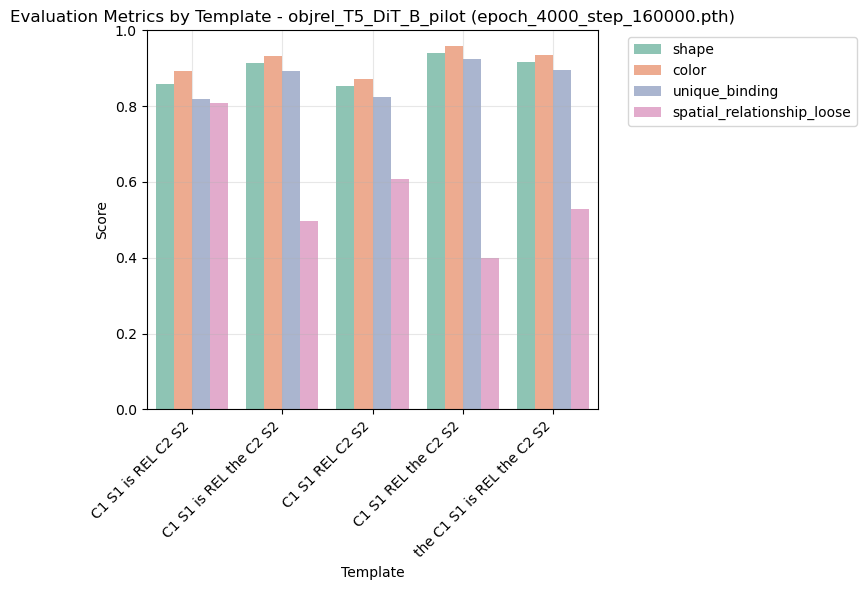

In [ ]:
import pandas as pd
from matplotlib.ticker import MultipleLocator
# Get the grouped data by template
template_means = eval_df_all_temp.groupby("template").mean(numeric_only=True)
# Select the key evaluation metrics to plot
# metrics_to_plot = ['overall', 'overall_loose', 'shape', 'color', 'exist_binding', 
#                    'unique_binding', 'spatial_relationship', 'spatial_relationship_loose']
metrics_to_plot = ['shape', 'color', 'unique_binding', 'spatial_relationship_loose']
# Create template name mapping for shorter labels
template_mapping_func = lambda x: x.replace('_', ' ').replace('rel text', 'REL').replace("color", "C").replace("shape", "S")
# Prepare data for seaborn - melt the dataframe to long format
plot_data = template_means[metrics_to_plot].reset_index()
# Apply template name mapping
plot_data['template_short'] = plot_data['template'].map(template_mapping_func).fillna(plot_data['template'])
plot_data_melted = pd.melt(plot_data, id_vars=['template_short'], 
                          value_vars=metrics_to_plot, 
                          var_name='metric', value_name='score')
# Create the bar plot using seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=plot_data_melted, x='template_short', y='score', hue='metric', 
                 palette='Set2', alpha=0.8)
# Customize the plot
ax.set_xlabel('Template')
ax.set_ylabel('Score')
ax.set_title(f'Evaluation Metrics by Template - {model_run_name} ({ckpt_name})')
plt.xticks(rotation=45, ha='right', fontsize=10)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.05))
plt.grid(axis='y', which='minor', linestyle=':', alpha=0.5)
ax.set_ylim(0, 1.0)
plt.tight_layout()
plt.show()

In [40]:
model_run_name = "objrel_rndembdposemb_DiT_B_pilot" # "objrel_rndembdposemb_DiT_B_pilot" 
# model_run_name = "objrel_T5_DiT_mini_pilot_WDecay" # "objrel_rndembdposemb_DiT_B_pilot" 
# ckpt_name = "epoch_4000_step_160000.pth" # "epoch_4000_step_160000.pth" 
ckpt_name = "epoch_4000_step_160000.pth" # "epoch_4000_step_160000.pth" 
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
# savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"
config = read_config(join(savedir, 'config.py'))
evaldir = join(savedir, "generalization_eval")
eval_df_all_temp = pd.read_csv(join(join(evaldir, f"eval_df_{ckpt_name}_ema_all_templates.csv")))
print(eval_df_all_temp.select_dtypes(include=['number', 'bool']).mean())
eval_df_all_temp.groupby("template").mean(numeric_only=True)

prompt_id                        131.500000
sample_id                         24.000000
overall                            0.719790
overall_loose                      0.840492
shape                              0.881262
color                              0.930056
exist_binding                      0.860173
unique_binding                     0.857189
spatial_relationship               0.719790
spatial_relationship_loose         0.840492
Dx                                -0.617715
Dy                                -0.701838
x1                                66.144725
y1                                64.233501
x2                                66.762441
y2                                64.935339
step_num                      160000.000000
ema                                1.000000
dtype: float64


,prompt_id,sample_id,overall,overall_loose,shape,color,exist_binding,unique_binding,spatial_relationship,spatial_relationship_loose,Dx,Dy,x1,y1,x2,y2,step_num,ema
template,,,,,,,,,,,,,,,,,,
color1_shape1_is_rel_text_color2_shape2,131.5,24.0,0.757808,0.842764,0.876546,0.927644,0.856756,0.854592,0.757808,0.842764,-0.356671,-0.856716,66.172230,64.331524,66.528901,65.188241,160000.0,1.0
color1_shape1_is_rel_text_the_color2_shape2,131.5,24.0,0.716759,0.862477,0.899814,0.942100,0.880566,0.877242,0.716759,0.862477,-0.283222,-0.384121,67.174833,64.520885,67.458054,64.905005,160000.0,1.0
color1_shape1_rel_text_color2_shape2,131.5,24.0,0.751546,0.822511,0.858380,0.909323,0.835189,0.832792,0.751546,0.822511,-1.215075,-1.622853,64.591664,64.198645,65.806739,65.821498,160000.0,1.0
color1_shape1_rel_text_the_color2_shape2,131.5,24.0,0.759122,0.842069,0.876701,0.925247,0.855519,0.853355,0.759122,0.842069,-0.327747,-1.236163,65.745901,64.039859,66.073648,65.276021,160000.0,1.0
the_color1_shape1_is_rel_text_the_color2_shape2,131.5,24.0,0.613714,0.832638,0.894867,0.945965,0.872835,0.867965,0.613714,0.832638,-0.924742,0.538564,66.958764,64.070360,67.883506,63.531796,160000.0,1.0


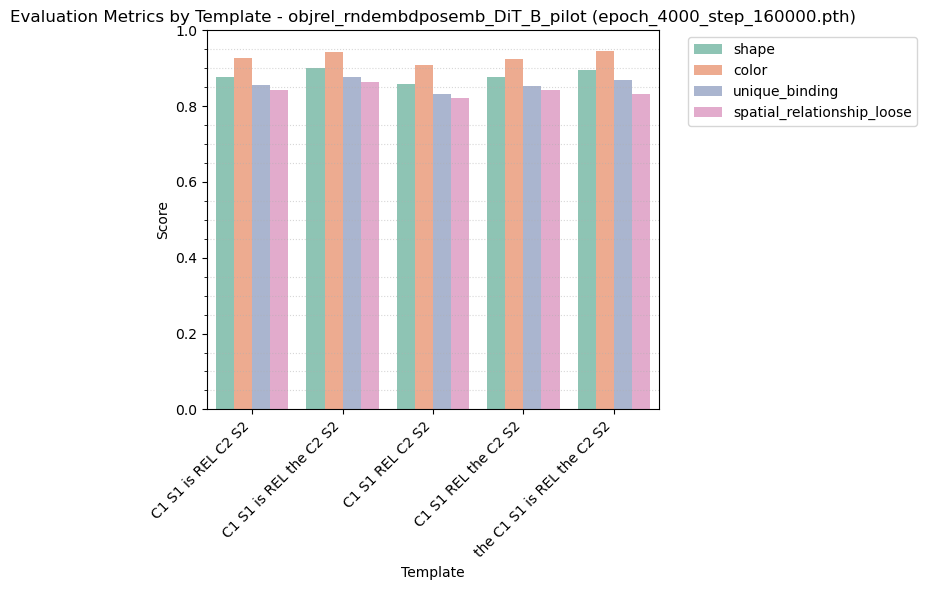

In [45]:

from matplotlib.ticker import MultipleLocator
# Get the grouped data by template
template_means = eval_df_all_temp.groupby("template").mean(numeric_only=True)
# Select the key evaluation metrics to plot
# metrics_to_plot = ['overall', 'overall_loose', 'shape', 'color', 'exist_binding', 
#                    'unique_binding', 'spatial_relationship', 'spatial_relationship_loose']
metrics_to_plot = ['shape', 'color', 'unique_binding', 'spatial_relationship_loose']
# Create template name mapping for shorter labels
# template_mapping = {
#     'color1_shape1_is_rel_text_color2_shape2': 'C1 S1 is REL C2 S2',
#     'color1_shape1_is_rel_text_the_color2_shape2': 'C1 S1 is REL the C2 S2',
#     'color1_shape1_rel_text_color2_shape2': 'C1 S1 REL C2 S2',
#     'color1_shape1_rel_text_the_color2_shape2': 'C1 S1 REL the C2 S2',
#     'the_color1_shape1_is_rel_text_the_color2_shape2': 'the C1 S1 is REL the C2 S2'
# }
template_mapping_func = lambda x: x.replace('_', ' ').replace('rel text', 'REL').replace("color", "C").replace("shape", "S")
# Prepare data for seaborn - melt the dataframe to long format
plot_data = template_means[metrics_to_plot].reset_index()
# Apply template name mapping
plot_data['template_short'] = plot_data['template'].map(template_mapping_func).fillna(plot_data['template'])
plot_data_melted = pd.melt(plot_data, id_vars=['template_short'], 
                          value_vars=metrics_to_plot, 
                          var_name='metric', value_name='score')
# Create the bar plot using seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=plot_data_melted, x='template_short', y='score', hue='metric', 
                 palette='Set2', alpha=0.8)
# Customize the plot
ax.set_xlabel('Template')
ax.set_ylabel('Score')
ax.set_title(f'Evaluation Metrics by Template - {model_run_name} ({ckpt_name})')
plt.xticks(rotation=45, ha='right', fontsize=10)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.grid(True, alpha=0.3, axis='y',)
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.05))
plt.grid(axis='y', which='minor', linestyle=':', alpha=0.5)
ax.set_ylim(0, 1.0)
plt.tight_layout()
plt.show()

### Mass produce plots

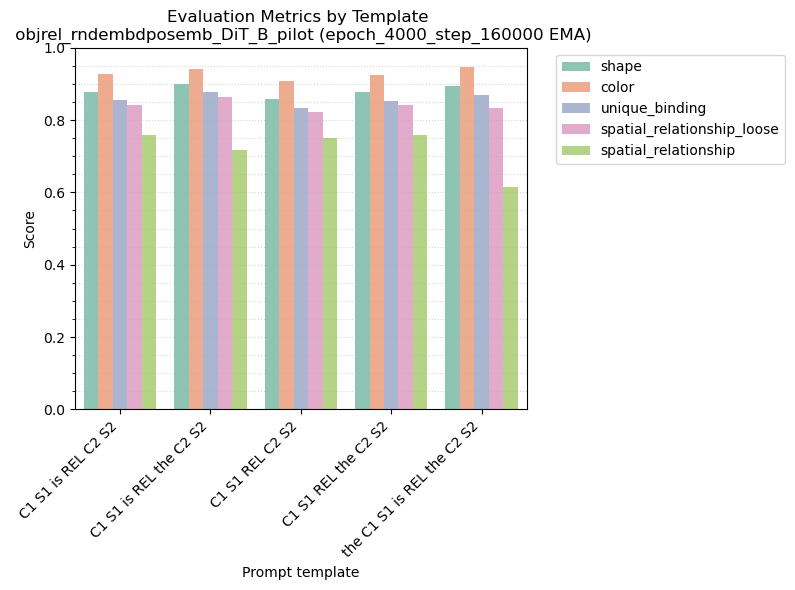

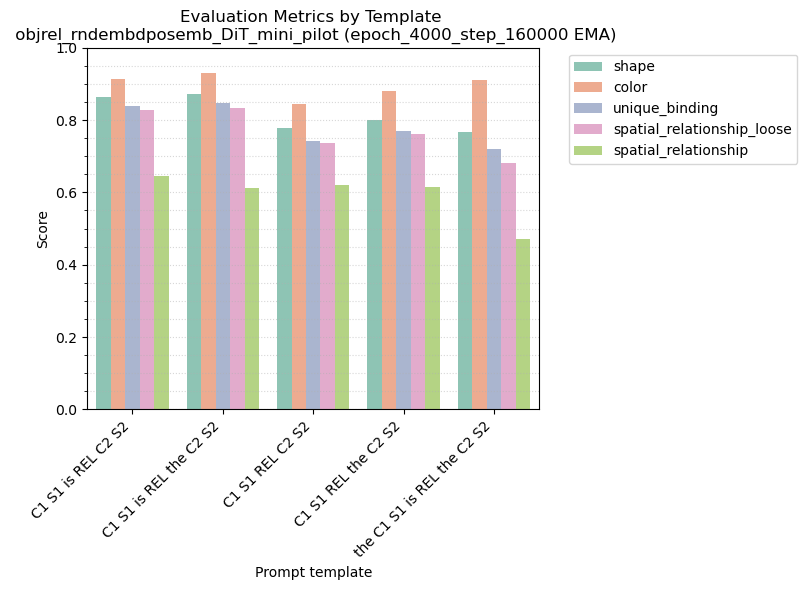

/tmp/ipykernel_3281862/4241731399.py:16: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df_all_temp = pd.read_csv(join(join(evaldir, f"eval_df_{ckpt_name}_ema_all_templates.csv")))


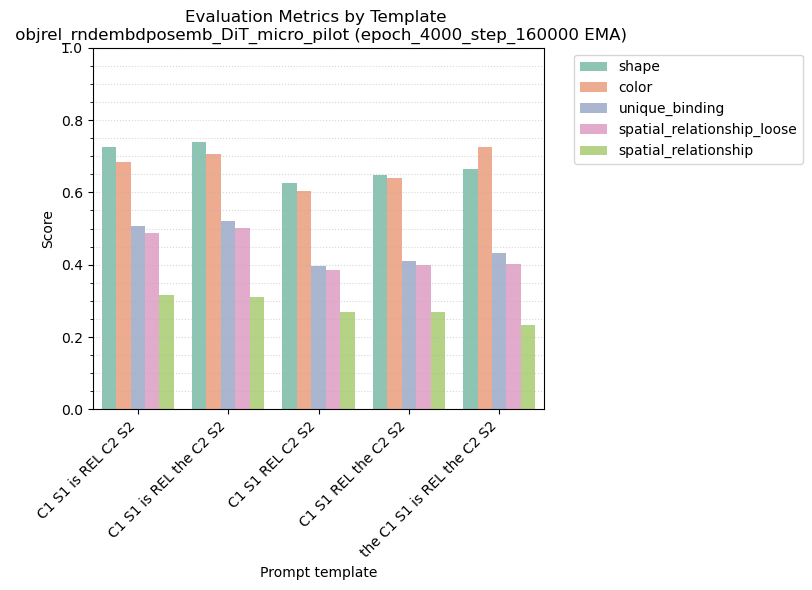

/tmp/ipykernel_3281862/4241731399.py:16: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df_all_temp = pd.read_csv(join(join(evaldir, f"eval_df_{ckpt_name}_ema_all_templates.csv")))


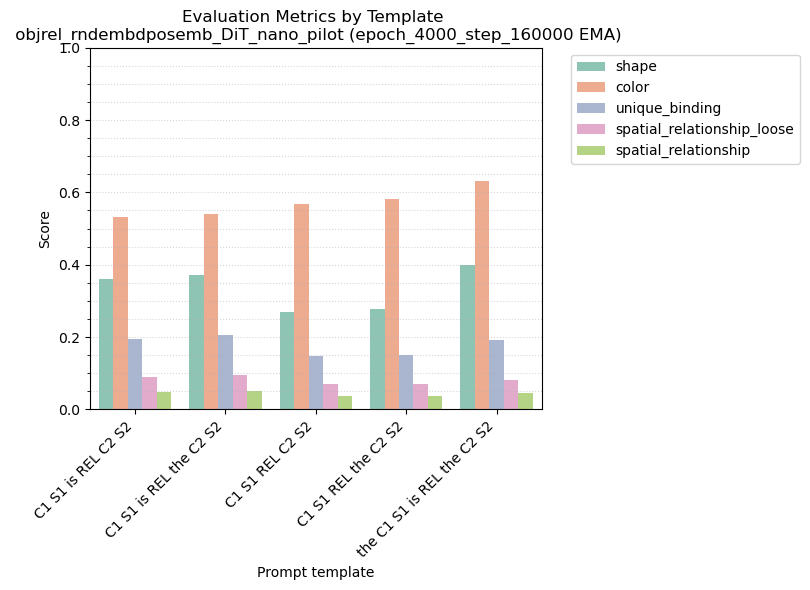

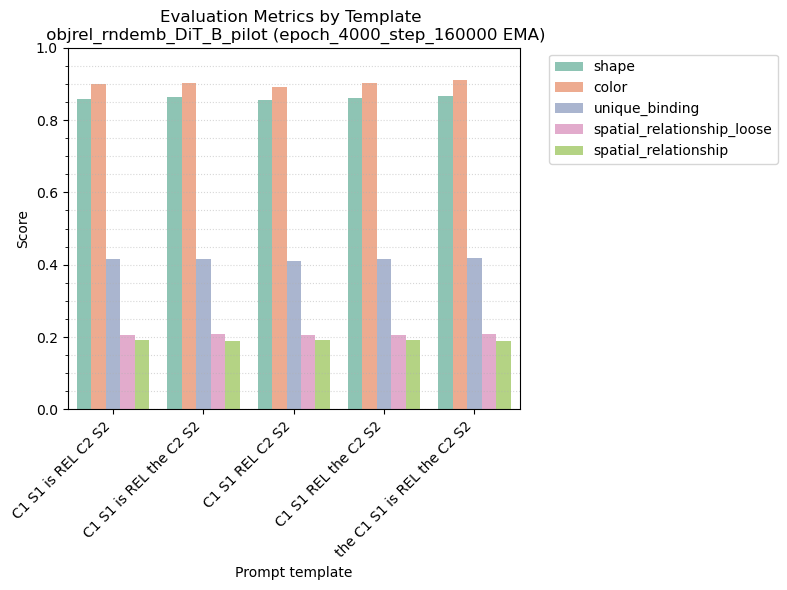

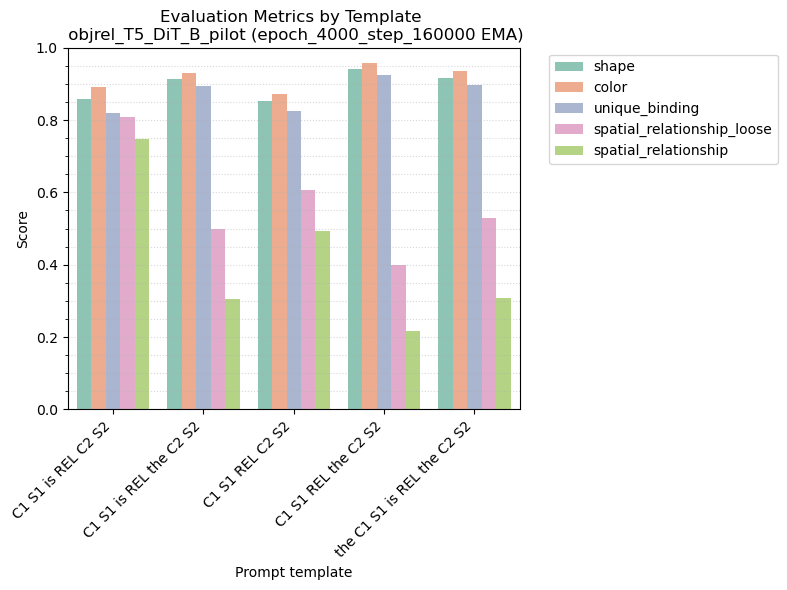

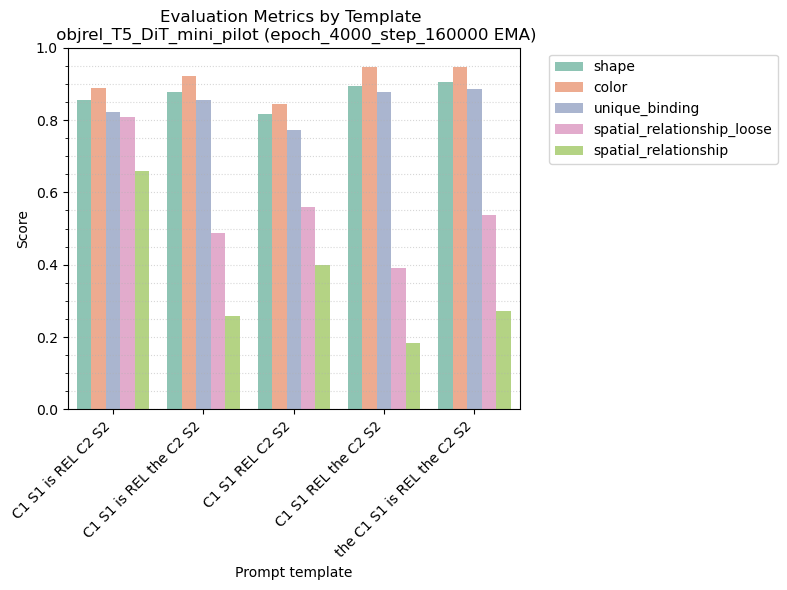

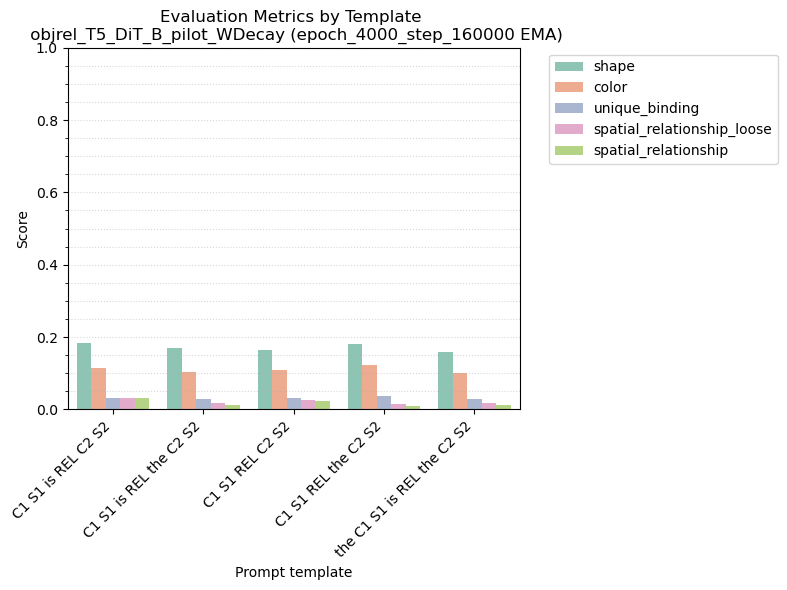

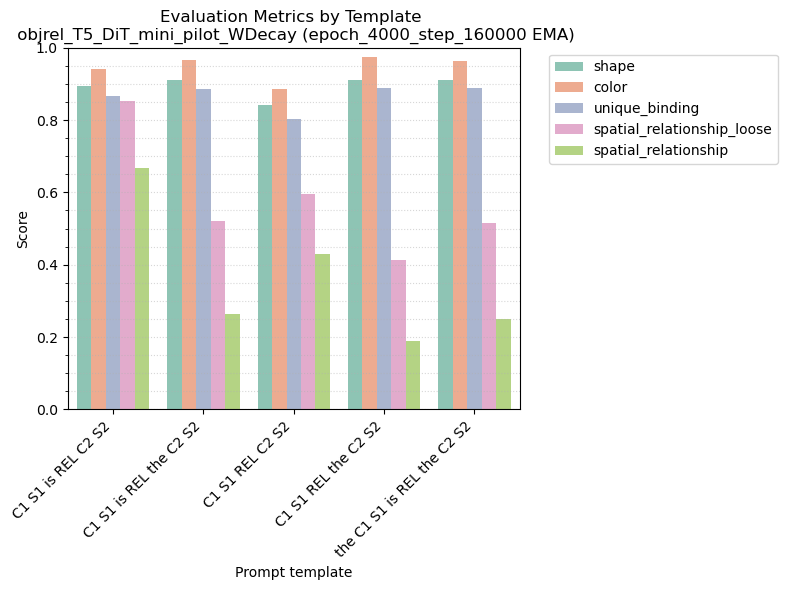

In [50]:
from matplotlib.ticker import MultipleLocator
for model_run_name in ["objrel_rndembdposemb_DiT_B_pilot", 
                       "objrel_rndembdposemb_DiT_mini_pilot",
                       "objrel_rndembdposemb_DiT_micro_pilot",
                       "objrel_rndembdposemb_DiT_nano_pilot",
                       "objrel_rndemb_DiT_B_pilot",
                       "objrel_T5_DiT_B_pilot",
                       "objrel_T5_DiT_mini_pilot",
                       "objrel_T5_DiT_B_pilot_WDecay",
                       "objrel_T5_DiT_mini_pilot_WDecay"]:
    ckpt_name = "epoch_4000_step_160000.pth" # "epoch_4000_step_160000.pth" 
    savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
    # savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"
    config = read_config(join(savedir, 'config.py'))
    evaldir = join(savedir, "generalization_eval")
    eval_df_all_temp = pd.read_csv(join(join(evaldir, f"eval_df_{ckpt_name}_ema_all_templates.csv")))
    # print(eval_df_all_temp.select_dtypes(include=['number', 'bool']).mean())
    # eval_df_all_temp.groupby("template").mean(numeric_only=True)

    # Get the grouped data by template
    template_means = eval_df_all_temp.groupby("template").mean(numeric_only=True)
    # Select the key evaluation metrics to plot
    # metrics_to_plot = ['overall', 'overall_loose', 'shape', 'color', 'exist_binding', 
    #                    'unique_binding', 'spatial_relationship', 'spatial_relationship_loose']
    metrics_to_plot = ['shape', 'color', 'unique_binding', 'spatial_relationship_loose', 'spatial_relationship',]
    template_mapping_func = lambda x: x.replace('_', ' ').replace('rel text', 'REL').replace("color", "C").replace("shape", "S")
    # Prepare data for seaborn - melt the dataframe to long format
    plot_data = template_means[metrics_to_plot].reset_index()
    # Apply template name mapping
    plot_data['template_short'] = plot_data['template'].map(template_mapping_func).fillna(plot_data['template'])
    plot_data_melted = pd.melt(plot_data, id_vars=['template_short'], 
                            value_vars=metrics_to_plot, 
                            var_name='metric', value_name='score')
    # Create the bar plot using seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(data=plot_data_melted, x='template_short', y='score', hue='metric', 
                    palette='Set2', alpha=0.8)
    # Customize the plot
    ax.set_xlabel('Prompt template')
    ax.set_ylabel('Score')
    ax.set_title(f'Evaluation Metrics by Template \n {model_run_name} ({ckpt_name.split(".")[0]} EMA)')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().yaxis.set_minor_locator(MultipleLocator(0.05))
    plt.grid(axis='y', which='both', linestyle=':', alpha=0.5)
    ax.set_ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

### Make a table of the models and a big export

In [12]:
from matplotlib.ticker import MultipleLocator
model_comparison_data = []
for model_run_name in ["objrel_rndembdposemb_DiT_B_pilot", 
                       "objrel_rndembdposemb_DiT_mini_pilot",
                       "objrel_rndembdposemb_DiT_micro_pilot",
                       "objrel_rndembdposemb_DiT_nano_pilot",
                       "objrel_rndemb_DiT_B_pilot",
                       "objrel_T5_DiT_B_pilot",
                       "objrel_T5_DiT_mini_pilot",
                       "objrel_T5_DiT_B_pilot_WDecay",
                       "objrel_T5_DiT_mini_pilot_WDecay"]:
    ckpt_name = "epoch_4000_step_160000.pth" # "epoch_4000_step_160000.pth" 
    savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
    # savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"
    config = read_config(join(savedir, 'config.py'))
    evaldir = join(savedir, "generalization_eval")
    eval_df_all_temp = pd.read_csv(join(join(evaldir, f"eval_df_{ckpt_name}_ema_all_templates.csv")))
    # print(eval_df_all_temp.select_dtypes(include=['number', 'bool']).mean())
    # eval_df_all_temp.groupby("template").mean(numeric_only=True)

    # Get the grouped data by template
    template_means = eval_df_all_temp.groupby("template").mean(numeric_only=True)
    # Add model name as a column for multiindex
    template_means['model_name'] = model_run_name
    template_means = template_means.reset_index()  # Reset index to make template a column
    model_comparison_data.append(template_means)

# Concatenate all data and create synopsis table with hierarchical index
synopsis_df = pd.concat(model_comparison_data, ignore_index=True)
synopsis_table = synopsis_df.set_index(['model_name', 'template'])

# Display the synopsis table
print("Synopsis Table - Model Performance by Template:")
print(synopsis_table[['shape', 'color',
       'exist_binding', 'unique_binding', 'spatial_relationship',
       'spatial_relationship_loose', 'Dx', 'Dy', 'x1', 'y1', 'x2', 'y2']])

/tmp/ipykernel_3820371/1365514019.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df_all_temp = pd.read_csv(join(join(evaldir, f"eval_df_{ckpt_name}_ema_all_templates.csv")))
/tmp/ipykernel_3820371/1365514019.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df_all_temp = pd.read_csv(join(join(evaldir, f"eval_df_{ckpt_name}_ema_all_templates.csv")))


Synopsis Table - Model Performance by Template:
                                                                                         shape  \
model_name                           template                                                    
objrel_rndembdposemb_DiT_B_pilot     color1_shape1_is_rel_text_color2_shape2          0.876546   
                                     color1_shape1_is_rel_text_the_color2_shape2      0.899814   
                                     color1_shape1_rel_text_color2_shape2             0.858380   
                                     color1_shape1_rel_text_the_color2_shape2         0.876701   
                                     the_color1_shape1_is_rel_text_the_color2_shape2  0.894867   
objrel_rndembdposemb_DiT_mini_pilot  color1_shape1_is_rel_text_color2_shape2          0.864951   
                                     color1_shape1_is_rel_text_the_color2_shape2      0.871212   
                                     color1_shape1_rel_text_color2_sha

In [14]:
# Define functions to shorten model names and template names
def shorten_model_name(name):
    # Remove common prefixes and suffixes
    name = name.replace('objrel_', '').replace('_pilot', '')
    name = name.replace('DiT_', 'DiT-')
    name = name.replace('rndembdposemb', 'rndpos').replace('rndemb', 'rnd')
    name = name.replace('WDecay', 'WD')
    name = name.replace("_", " ")
    return name

def shorten_template_name(template):
    # Shorten common template patterns
    # template = template.replace('color1_shape1_', 'C1S1_')
    # template = template.replace('color2_shape2', 'C2S2')
    template = template.replace('color1_shape1_', 'Obj1_')
    template = template.replace('color2_shape2', 'Obj2')
    template = template.replace('_rel_text_', '_REL_')
    template = template.replace("_", " ")
    return template

# Create a copy of synopsis_table with shortened names
synopsis_short = synopsis_table.copy()
synopsis_short.index = synopsis_short.index.set_levels([
    [shorten_model_name(name) for name in synopsis_short.index.levels[0]],
    [shorten_template_name(template) for template in synopsis_short.index.levels[1]]
], level=[0, 1])

# Select and print specific columns from the synopsis table
selected_columns = ['shape', 'color', 'unique_binding', 
                   'spatial_relationship', 'spatial_relationship_loose', 
                   'Dx', 'Dy', 'x1', 'y1', 'x2', 'y2']
synopsis_short[selected_columns].round(3)

shape  color  unique_binding  \
model_name       template                                                 
rndpos DiT-B     Obj1 is REL Obj2          0.877  0.928           0.855   
                 Obj1 is REL the Obj2      0.900  0.942           0.877   
                 Obj1 REL Obj2             0.858  0.909           0.833   
                 Obj1 REL the Obj2         0.877  0.925           0.853   
                 the Obj1 is REL the Obj2  0.895  0.946           0.868   
rndpos DiT-mini  Obj1 is REL Obj2          0.865  0.914           0.838   
                 Obj1 is REL the Obj2      0.871  0.931           0.847   
                 Obj1 REL Obj2             0.778  0.845           0.743   
                 Obj1 REL the Obj2         0.799  0.879           0.770   
                 the Obj1 is REL the Obj2  0.767  0.912           0.721   
rndpos DiT-micro Obj1 is REL Obj2          0.726  0.683           0.508   
                 Obj1 is REL the Obj2      0.738  0.705           0.520   
                 Obj1 REL Obj2             0.626  0.604           0.395   
                 Obj1 REL the Obj2         0.649  0.639           0.410   
                 the Obj1 is REL the Obj2  0.665  0.724           0.432   
rndpos DiT-nano  Obj1 is REL Obj2          0.360  0.531           0.195   
                 Obj1 is REL the Obj2      0.372  0.539           0.205   
                 Obj1 REL Obj2             0.270  0.568           0.146   
                 Obj1 REL the Obj2         0.279  0.581           0.151   
                 the Obj1 is REL the Obj2  0.399  0.632           0.193   
rnd DiT-B        Obj1 is REL Obj2          0.859  0.899           0.415   
                 Obj1 is REL the Obj2      0.863  0.903           0.416   
                 Obj1 REL Obj2             0.856  0.893           0.412   
                 Obj1 REL the Obj2         0.860  0.902           0.415   
                 the Obj1 is REL the Obj2  0.866  0.910           0.417   
T5 DiT-B         Obj1 is REL Obj2          0.857  0.892           0.820   
                 Obj1 is REL the Obj2      0.915  0.931           0.894   
                 Obj1 REL Obj2             0.853  0.871           0.825   
                 Obj1 REL the Obj2         0.941  0.958           0.925   
                 the Obj1 is REL the Obj2  0.917  0.935           0.896   
T5 DiT-mini      Obj1 is REL Obj2          0.856  0.889           0.822   
                 Obj1 is REL the Obj2      0.877  0.922           0.855   
                 Obj1 REL Obj2             0.816  0.844           0.772   
                 Obj1 REL the Obj2         0.895  0.946           0.878   
                 the Obj1 is REL the Obj2  0.906  0.947           0.885   
T5 DiT-B WD      Obj1 is REL Obj2          0.183  0.114           0.033   
                 Obj1 is REL the Obj2      0.169  0.104           0.030   
                 Obj1 REL Obj2             0.164  0.110           0.032   
                 Obj1 REL the Obj2         0.181  0.122           0.037   
                 the Obj1 is REL the Obj2  0.160  0.100           0.028   
T5 DiT-mini WD   Obj1 is REL Obj2          0.894  0.942           0.866   
                 Obj1 is REL the Obj2      0.911  0.967           0.886   
                 Obj1 REL Obj2             0.843  0.886           0.804   
                 Obj1 REL the Obj2         0.911  0.975           0.888   
                 the Obj1 is REL the Obj2  0.911  0.965           0.887   

                                           spatial_relationship  \
model_name       template                                         
rndpos DiT-B     Obj1 is REL Obj2                         0.758   
                 Obj1 is REL the Obj2                     0.717   
                 Obj1 REL Obj2                            0.752   
                 Obj1 REL the Obj2                        0.759   
                 the Obj1 is REL the Obj2                 0.614   
rndpos DiT-mini  Obj1 is REL Obj2               

In [19]:
# Define functions to shorten model names and template names
def shorten_model_name(name):
    # Remove common prefixes and suffixes
    name = name.replace('objrel_', '').replace('_pilot', '')
    name = name.replace('DiT_', 'DiT-')
    name = name.replace('rndembdposemb', 'rndpos').replace('rndemb', 'rnd')
    name = name.replace('WDecay', 'WD')
    name = name.replace("_", " ")
    return name

def shorten_template_name(template):
    # Shorten common template patterns
    # template = template.replace('color1_shape1_', 'C1S1_')
    # template = template.replace('color2_shape2', 'C2S2')
    template = template.replace('color1_shape1', 'O1')
    template = template.replace('color2_shape2', 'O2')
    template = template.replace('_rel_text_', '_Rel_')
    template = template.replace("_", " ")
    return template

# Create a copy of synopsis_table with shortened names
synopsis_short = synopsis_table.copy()
synopsis_short.index = synopsis_short.index.set_levels([
    [shorten_model_name(name) for name in synopsis_short.index.levels[0]],
    [shorten_template_name(template) for template in synopsis_short.index.levels[1]]
], level=[0, 1])

# Select and print specific columns from the synopsis table
selected_columns = ['shape', 'color', 'unique_binding', 
                   'spatial_relationship_loose', 'spatial_relationship', 
                   'Dx', 'Dy', 'x1', 'y1', 'x2', 'y2']
# Rename columns for shorter display
column_renames = {
    'shape': 'shape',
    'color': 'color', 
    'unique_binding': 'bind',
    'spatial_relationship_loose': 'rel',
    'spatial_relationship': 'rel*',
    'Dx': 'Dx',
    'Dy': 'Dy',
    'x1': 'x1',
    'y1': 'y1', 
    'x2': 'x2',
    'y2': 'y2'
}

synopsis_display = synopsis_short[selected_columns].rename(columns=column_renames)
synopsis_display
# Export synopsis table to LaTeX
# print("LaTeX format:")
print(synopsis_display.to_latex(float_format='%.3f'))


\begin{tabular}{llrrrrrrrrrrr}
\toprule
 &  & shape & color & bind & rel & rel* & Dx & Dy & x1 & y1 & x2 & y2 \\
model_name & template &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{rndpos DiT-B} & O1 is Rel O2 & 0.877 & 0.928 & 0.855 & 0.843 & 0.758 & -0.357 & -0.857 & 66.172 & 64.332 & 66.529 & 65.188 \\
 & O1 is Rel the O2 & 0.900 & 0.942 & 0.877 & 0.862 & 0.717 & -0.283 & -0.384 & 67.175 & 64.521 & 67.458 & 64.905 \\
 & O1 Rel O2 & 0.858 & 0.909 & 0.833 & 0.823 & 0.752 & -1.215 & -1.623 & 64.592 & 64.199 & 65.807 & 65.821 \\
 & O1 Rel the O2 & 0.877 & 0.925 & 0.853 & 0.842 & 0.759 & -0.328 & -1.236 & 65.746 & 64.040 & 66.074 & 65.276 \\
 & the O1 is Rel the O2 & 0.895 & 0.946 & 0.868 & 0.833 & 0.614 & -0.925 & 0.539 & 66.959 & 64.070 & 67.884 & 63.532 \\
\cline{1-13}
\multirow[t]{5}{*}{rndpos DiT-mini} & O1 is Rel O2 & 0.865 & 0.914 & 0.838 & 0.828 & 0.644 & 0.799 & 0.440 & 65.738 & 64.537 & 64.940 & 64.097 \\
 & O1 is Rel the O2 & 0.871 & 0.931 & 0.847 & 0.834 & 0

In [ ]:
# Define functions to shorten model names and template names
def shorten_model_name(name):
    # Remove common prefixes and suffixes
    name = name.replace('objrel_', '').replace('_pilot', '')
    name = name.replace('DiT_', 'DiT-')
    name = name.replace('rndembdposemb', 'rndpos').replace('rndemb', 'rnd')
    name = name.replace('WDecay', 'WD')
    name = name.replace("_", " ")
    return name

def shorten_template_name(template):
    # Shorten common template patterns
    # template = template.replace('color1_shape1_', 'C1S1_')
    # template = template.replace('color2_shape2', 'C2S2')
    template = template.replace('color1_shape1', 'O1')
    template = template.replace('color2_shape2', 'O2')
    template = template.replace('_rel_text_', '_Rel_')
    template = template.replace("_", " ")
    return template

# Create a copy of synopsis_table with shortened names
synopsis_short = synopsis_table.copy()
synopsis_short.index = synopsis_short.index.set_levels([
    [shorten_model_name(name) for name in synopsis_short.index.levels[0]],
    [shorten_template_name(template) for template in synopsis_short.index.levels[1]]
], level=[0, 1])

# Select and print specific columns from the synopsis table
selected_columns = ['shape', 'color', 'unique_binding', 
                   'spatial_relationship_loose', 'spatial_relationship', 
                   'Dx', 'Dy']
# Rename columns for shorter display
column_renames = {
    'shape': 'shape',
    'color': 'color', 
    'unique_binding': 'bind',
    'spatial_relationship_loose': 'rel',
    'spatial_relationship': 'rel*',
    'Dx': 'Dx',
    'Dy': 'Dy',
}

synopsis_display = synopsis_short[selected_columns].rename(columns=column_renames)
synopsis_display
# Export synopsis table to LaTeX
# print("LaTeX format:")
# Custom formatting for different precision requirements
latex_formatters = {
    'shape': lambda x: f'{x:.3f}',
    'color': lambda x: f'{x:.3f}',
    'bind': lambda x: f'{x:.3f}',
    'rel': lambda x: f'{x:.3f}',
    'rel*': lambda x: f'{x:.3f}',
    'Dx': lambda x: f'{x:.1f}',
    'Dy': lambda x: f'{x:.1f}'
}
print(synopsis_display.to_latex(formatters=latex_formatters))

\begin{tabular}{llrrrrrrr}
\toprule
 &  & shape & color & bind & rel & rel* & Dx & Dy \\
model_name & template &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{rndpos DiT-B} & O1 is Rel O2 & 0.877 & 0.928 & 0.855 & 0.843 & 0.758 & -0.4 & -0.9 \\
 & O1 is Rel the O2 & 0.900 & 0.942 & 0.877 & 0.862 & 0.717 & -0.3 & -0.4 \\
 & O1 Rel O2 & 0.858 & 0.909 & 0.833 & 0.823 & 0.752 & -1.2 & -1.6 \\
 & O1 Rel the O2 & 0.877 & 0.925 & 0.853 & 0.842 & 0.759 & -0.3 & -1.2 \\
 & the O1 is Rel the O2 & 0.895 & 0.946 & 0.868 & 0.833 & 0.614 & -0.9 & 0.5 \\
\cline{1-9}
\multirow[t]{5}{*}{rndpos DiT-mini} & O1 is Rel O2 & 0.865 & 0.914 & 0.838 & 0.828 & 0.644 & 0.8 & 0.4 \\
 & O1 is Rel the O2 & 0.871 & 0.931 & 0.847 & 0.834 & 0.613 & 1.1 & 1.5 \\
 & O1 Rel O2 & 0.778 & 0.845 & 0.743 & 0.737 & 0.621 & 1.5 & -0.4 \\
 & O1 Rel the O2 & 0.799 & 0.879 & 0.770 & 0.762 & 0.616 & 1.8 & 0.0 \\
 & the O1 is Rel the O2 & 0.767 & 0.912 & 0.721 & 0.680 & 0.471 & -0.1 & 1.8 \\
\cline{1-9}
\multirow[t]{5}{*}{rndpo

In [ ]:
print("\n" + "="*80 + "\n")
# Export synopsis table to Markdown
print("Markdown format:")
print(synopsis_short[selected_columns].round(3).to_markdown())

### Synopsis bar

In [24]:
synopsis_table

prompt_id  \
model_name                           template                                                     
objrel_rndembdposemb_DiT_B_pilot     color1_shape1_is_rel_text_color2_shape2              131.5   
                                     color1_shape1_is_rel_text_the_color2_shape2          131.5   
                                     color1_shape1_rel_text_color2_shape2                 131.5   
                                     color1_shape1_rel_text_the_color2_shape2             131.5   
                                     the_color1_shape1_is_rel_text_the_color2_shape2      131.5   
objrel_rndembdposemb_DiT_mini_pilot  color1_shape1_is_rel_text_color2_shape2              131.5   
                                     color1_shape1_is_rel_text_the_color2_shape2          131.5   
                                     color1_shape1_rel_text_color2_shape2                 131.5   
                                     color1_shape1_rel_text_the_color2_shape2             131.5   
                                     the_color1_shape1_is_rel_text_the_color2_shape2      131.5   
objrel_rndembdposemb_DiT_micro_pilot color1_shape1_is_rel_text_color2_shape2              131.5   
                                     color1_shape1_is_rel_text_the_color2_shape2          131.5   
                                     color1_shape1_rel_text_color2_shape2                 131.5   
                                     color1_shape1_rel_text_the_color2_shape2             131.5   
                                     the_color1_shape1_is_rel_text_the_color2_shape2      131.5   
objrel_rndembdposemb_DiT_nano_pilot  color1_shape1_is_rel_text_color2_shape2              131.5   
                                     color1_shape1_is_rel_text_the_color2_shape2          131.5   
                                     color1_shape1_rel_text_color2_shape2                 131.5   
                                     color1_shape1_rel_text_the_color2_shape2             131.5   
                                     the_color1_shape1_is_rel_text_the_color2_shape2      131.5   
objrel_rndemb_DiT_B_pilot            color1_shape1_is_rel_text_color2_shape2              131.5   
                                     color1_shape1_is_rel_text_the_color2_shape2          131.5   
                                     color1_shape1_rel_text_color2_shape2                 131.5   
                                     color1_shape1_rel_text_the_color2_shape2             131.5   
                                     the_color1_shape1_is_rel_text_the_color2_shape2      131.5   
objrel_T5_DiT_B_pilot                color1_shape1_is_rel_text_color2_shape2              131.5   
                                     color1_shape1_is_rel_text_the_color2_shape2          131.5   
                                     color1_shape1_rel_text_color2_shape2                 131.5   
                                     color1_shape1_rel_text_the_color2_shape2             131.5   
                                     the_color1_shape1_is_rel_text_the_color2_shape2      131.5   
objrel_T5_DiT_mini_pilot             color1_shape1_is_rel_text_color2_shape2              131.5   
                                     color1_shape1_is_rel_text_the_color2_shape2          131.5   
                                     color1_shape1_rel_text_color2_shape2                 131.5   
                                     color1_shape1_rel_text_the_color2_shape2             131.5   
                                     the_color1_shape1_is_rel_text_the_color2_shape2      131.5   
objrel_T5_DiT_B_pilot_WDecay         color1_shape1_is_rel_text_color2_shape2              131.5   
                                     color1_shape1_is_rel_text_the_color2_shape2          131.5   
                                     color1_shape1_rel_text_color2_shape2                 131.5   
                                     color1_shape1_rel_text_the_color2_shape2             131.5   
                           

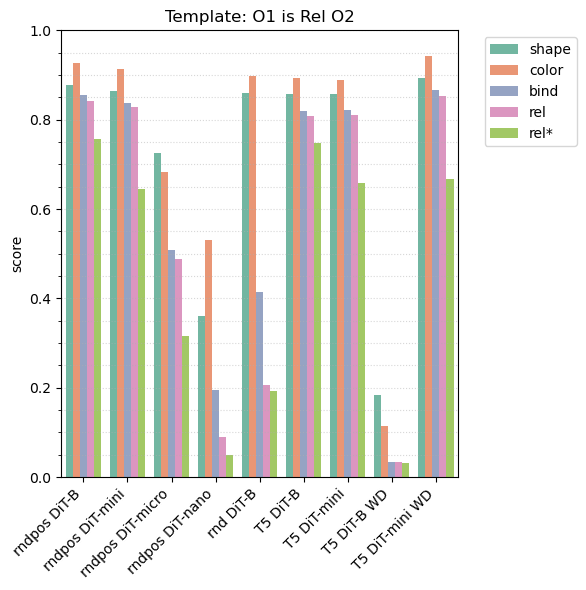

In [33]:
# Plot synopsis table as bar plot focusing on one template
import seaborn as sns
import matplotlib.pyplot as plt

# Select one template to focus on
template_name = synopsis_display.index.levels[1][0]
template_data = synopsis_display.xs(template_name, level=1)

# Melt the data for seaborn
plot_data = template_data.reset_index().melt(id_vars='model_name', var_name='metric', value_name='value')

# Create bar plot
plt.figure(figsize=(6, 6))
# Filter out Dx and Dy metrics
plot_data_filtered = plot_data[~plot_data['metric'].isin(['Dx', 'Dy'])]
sns.barplot(data=plot_data_filtered, x='model_name', y='value', 
            hue='metric', palette="Set2")
plt.title(f'Template: {template_name}')
plt.xlabel("")
plt.ylabel("score")
plt.xticks(rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.05))
plt.grid(axis='y', which='both', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

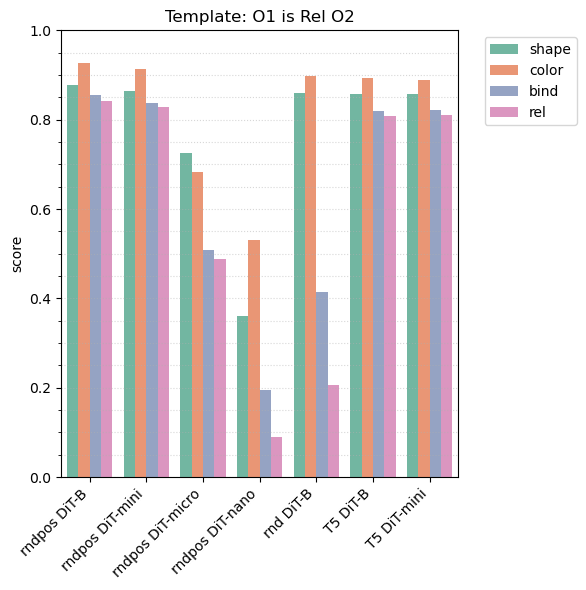

In [ ]:
# Select one template to focus on
template_name = synopsis_display.index.levels[1][0]
template_data = synopsis_display.xs(template_name, level=1)

# Melt the data for seaborn
plot_data = template_data.reset_index().melt(id_vars='model_name', var_name='metric', value_name='value')

# Create bar plot
plt.figure(figsize=(6, 6))
# Filter out Dx and Dy metrics
plot_data_filtered = plot_data[~plot_data['metric'].isin(['Dx', 'Dy', 'rel*'])]
plot_data_filtered = plot_data_filtered[~plot_data_filtered['model_name'].str.contains('WD')]
# plot_data_filtered
sns.barplot(data=plot_data_filtered, x='model_name', y='value', 
            hue='metric', palette="Set2")
plt.title(f'Template: {template_name}')
plt.xlabel("")
plt.ylabel("score")
plt.xticks(rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.05))
plt.grid(axis='y', which='both', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

### Mass prod Eval synopsis saving

In [36]:
synopsis_dir = f"/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/model_eval_synopsis"

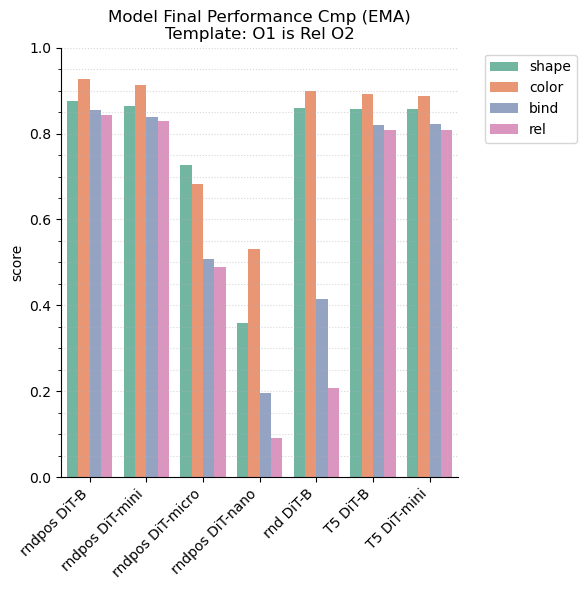

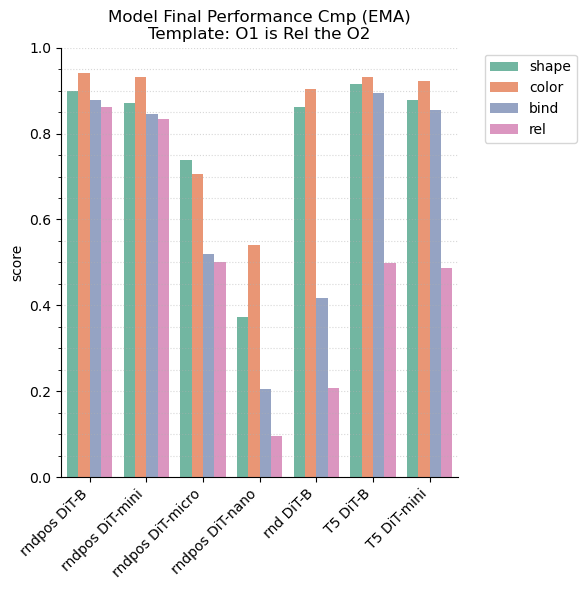

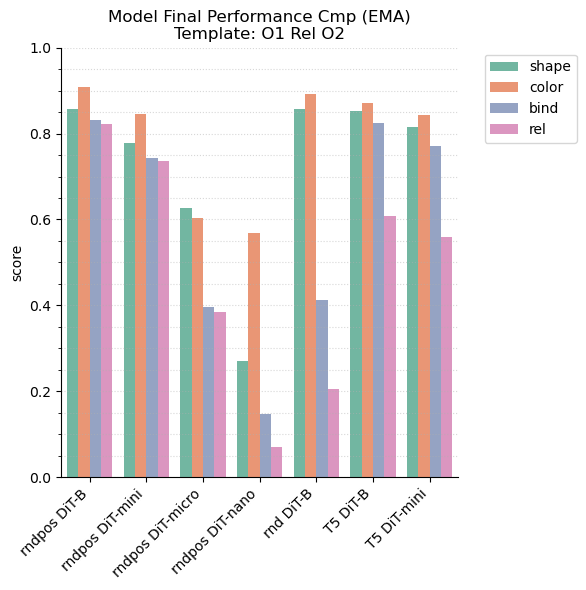

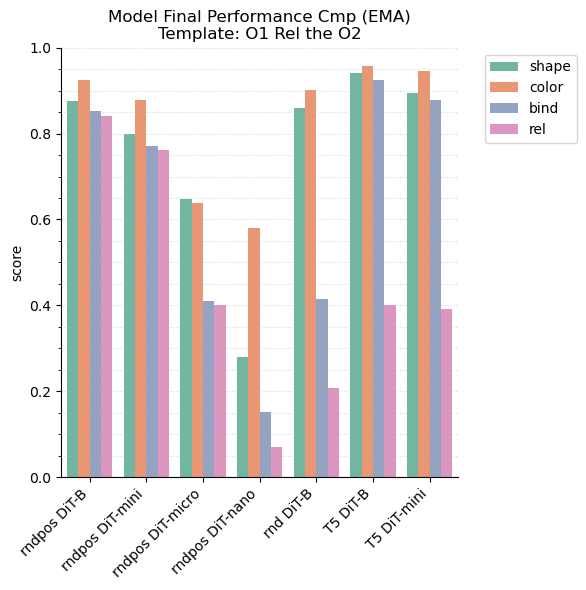

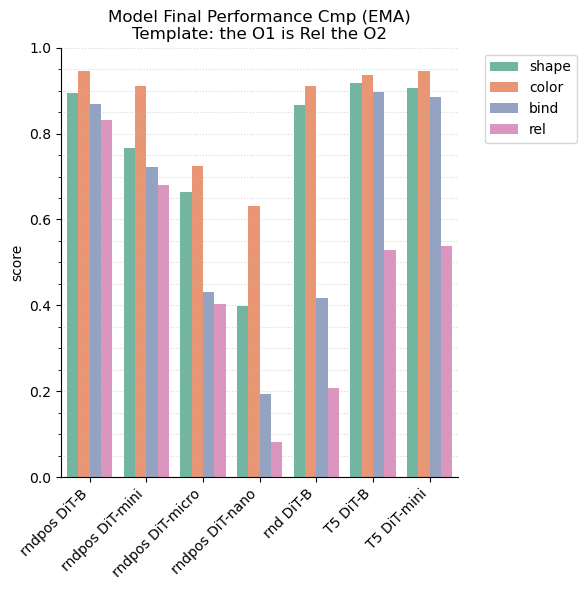

In [40]:
# Loop over all templates
for template_name in synopsis_display.index.levels[1]:
    template_data = synopsis_display.xs(template_name, level=1)

    # Melt the data for seaborn
    plot_data = template_data.reset_index().melt(id_vars='model_name', var_name='metric', value_name='value')

    # Create bar plot
    plt.figure(figsize=(6, 6))
    # Filter out Dx and Dy metrics
    plot_data_filtered = plot_data[~plot_data['metric'].isin(['Dx', 'Dy', 'rel*'])]
    plot_data_filtered = plot_data_filtered[~plot_data_filtered['model_name'].str.contains('WD')]
    # plot_data_filtered
    sns.barplot(data=plot_data_filtered, x='model_name', y='value', 
                hue='metric', palette="Set2")
    plt.title(f'Model Final Performance Cmp (EMA)\nTemplate: {template_name}')
    plt.xlabel("")
    plt.ylabel("score")
    plt.xticks(rotation=45, ha="right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 1)
    plt.gca().yaxis.set_minor_locator(MultipleLocator(0.05))
    plt.grid(axis='y', which='both', linestyle=':', alpha=0.5)
    plt.tight_layout()
    saveallforms(synopsis_dir, f"all_model_ema_cmp_prune_template_{template_name.replace(' ','_')}")
    plt.show()

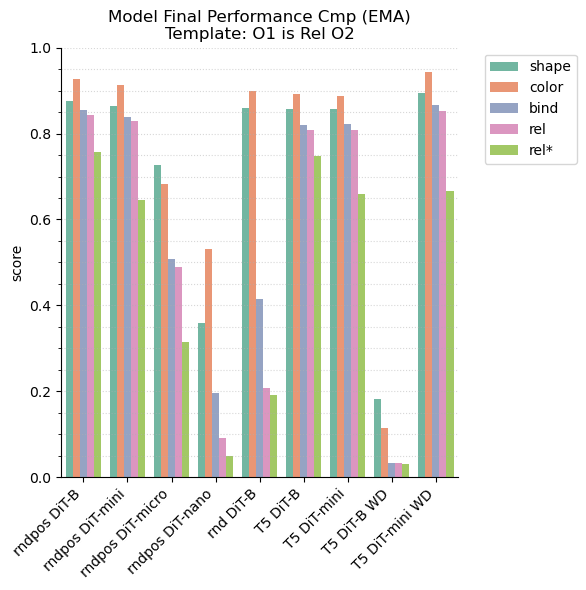

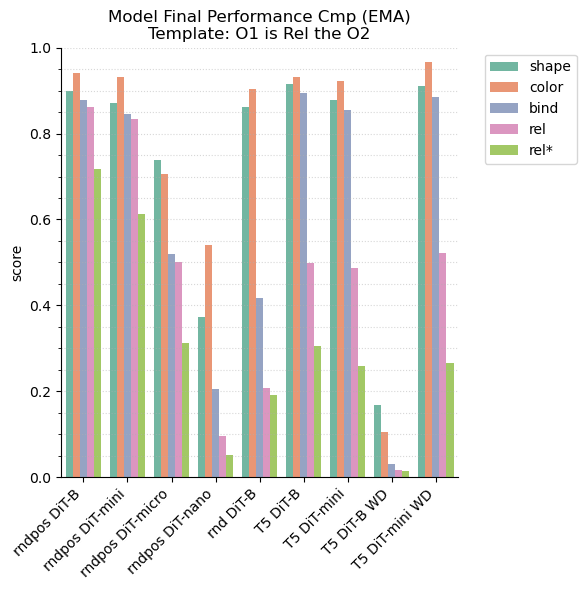

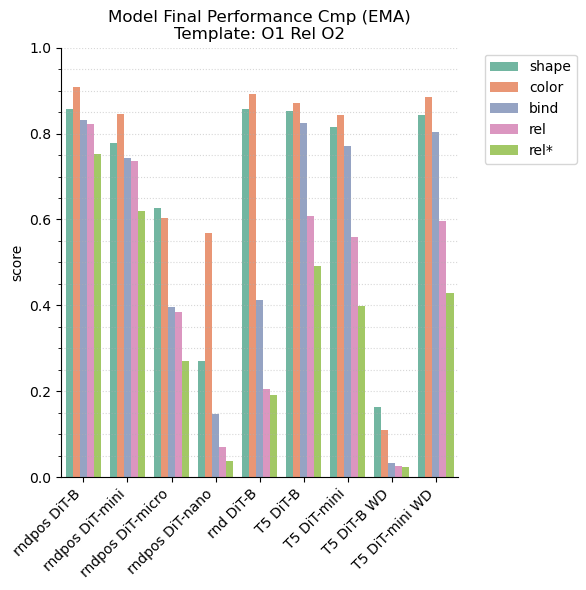

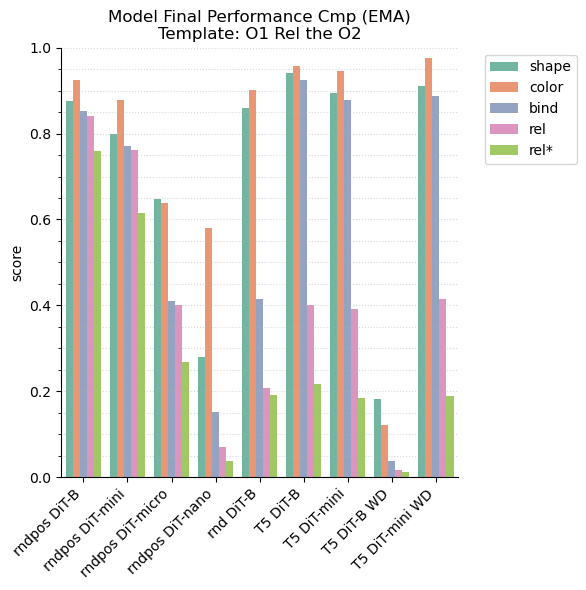

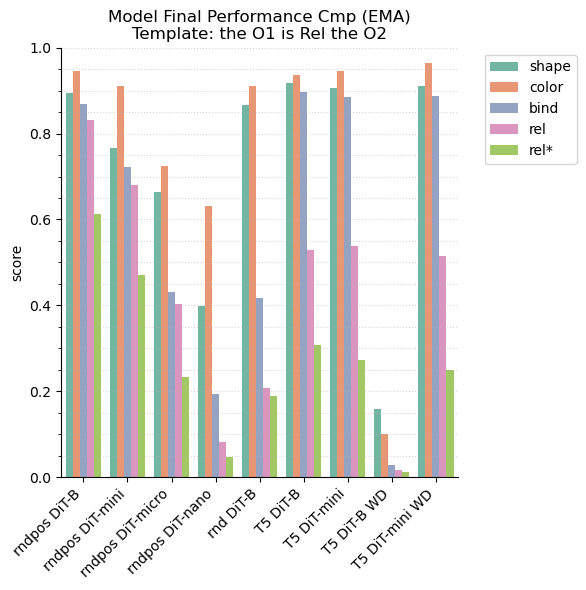

In [41]:
# Loop over all templates
for template_name in synopsis_display.index.levels[1]:
    template_data = synopsis_display.xs(template_name, level=1)

    # Melt the data for seaborn
    plot_data = template_data.reset_index().melt(id_vars='model_name', var_name='metric', value_name='value')

    # Create bar plot
    plt.figure(figsize=(6, 6))
    # Filter out Dx and Dy metrics
    plot_data_filtered = plot_data[~plot_data['metric'].isin(['Dx', 'Dy', ])]
    # plot_data_filtered = plot_data_filtered[~plot_data_filtered['model_name'].str.contains('WD')]
    # plot_data_filtered
    sns.barplot(data=plot_data_filtered, x='model_name', y='value', 
                hue='metric', palette="Set2")
    plt.title(f'Model Final Performance Cmp (EMA)\nTemplate: {template_name}')
    plt.xlabel("")
    plt.ylabel("score")
    plt.xticks(rotation=45, ha="right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 1)
    plt.gca().yaxis.set_minor_locator(MultipleLocator(0.05))
    plt.grid(axis='y', which='both', linestyle=':', alpha=0.5)
    plt.tight_layout()
    saveallforms(synopsis_dir, f"all_model_ema_cmp_full_template_{template_name.replace(' ','_')}")
    plt.show()

### Training trajectory

In [43]:
!ls {evaldir}

eval_df_all_checkpoints_all_templates.csv
eval_df_epoch_4000_step_160000.pth_ema_all_templates.csv
eval_df_epoch_4000_step_160000.pth_ema_color1_shape1_is_rel_text_color2_shape2.csv
eval_df_epoch_4000_step_160000.pth_ema_color1_shape1_is_rel_text_the_color2_shape2.csv
eval_df_epoch_4000_step_160000.pth_ema_color1_shape1_rel_text_color2_shape2.csv
eval_df_epoch_4000_step_160000.pth_ema_color1_shape1_rel_text_the_color2_shape2.csv
eval_df_epoch_4000_step_160000.pth_ema_the_color1_shape1_is_rel_text_the_color2_shape2.csv
eval_df_epoch_4000_step_160000.pth_model_all_templates.csv
eval_df_epoch_4000_step_160000.pth_model_color1_shape1_is_rel_text_color2_shape2.csv
eval_df_epoch_4000_step_160000.pth_model_color1_shape1_is_rel_text_the_color2_shape2.csv
eval_df_epoch_4000_step_160000.pth_model_color1_shape1_rel_text_color2_shape2.csv
eval_df_epoch_4000_step_160000.pth_model_color1_shape1_rel_text_the_color2_shape2.csv
eval_df_epoch_4000_step_160000.pth_model_the_color1_shape1_is_rel_text_the_

/tmp/ipykernel_3820371/1969093615.py:20: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_checkpoints_all_templates.csv"))


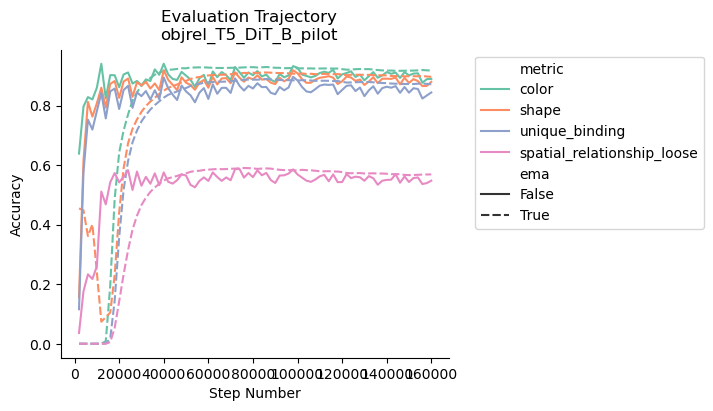

/tmp/ipykernel_3820371/1969093615.py:20: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_checkpoints_all_templates.csv"))


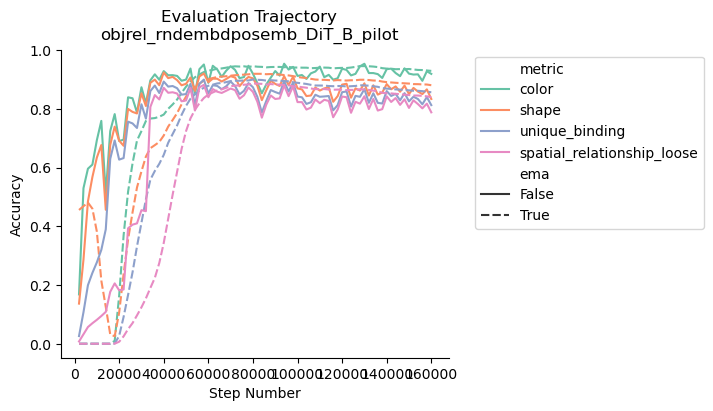

In [ ]:
synopsis_dir = f"/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/model_eval_synopsis"
os.makedirs(synopsis_dir, exist_ok=True)
for model_run_name in [
                        "objrel_T5_DiT_B_pilot",
                        # "objrel_T5_DiT_mini_pilot", 
                        "objrel_rndembdposemb_DiT_B_pilot",
                        # "objrel_rndembdposemb_DiT_micro_pilot",
                        # "objrel_rndembdposemb_DiT_nano_pilot",
                        # "objrel_rndembdposemb_DiT_mini_pilot",
                        # "objrel_rndemb_DiT_B_pilot",
                        # "objrel_T5_DiT_B_pilot_WDecay",
                        # "objrel_T5_DiT_mini_pilot_WDecay"
                        ]:
    savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
    # figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
    # result_dir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}"
    eval_dir = join(savedir, "generalization_eval")
    
    # eval_df_all_temp = pd.read_csv(join(join(evaldir, f"eval_df_{ckpt_name}_ema_all_templates.csv")))
    eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_checkpoints_all_templates.csv"))
    # object_df_all_traj = pd.read_pickle(join(eval_dir, f"object_df_all_train_traj_prompts.pkl"))
    # eval_df_all_traj['spatial_relation_loose'] = evaluate_spatial_relation_loose_vectorized(eval_df_all_traj, threshold = 8)
    eval_df_all_traj_syn = eval_df_all_traj.groupby(["step_num", "ema"]).mean(numeric_only=True).reset_index()
    # eval_df_all_traj_syn.droplevel
    # 1) melt into long form
    df_long = eval_df_all_traj_syn.reset_index().melt(
        id_vars=["step_num", "ema"],
        # value_vars=["color", "shape", "exist_binding", "unique_binding", "spatial_relationship", "spatial_relationship_loose"],
        value_vars=["color", "shape", "unique_binding", "spatial_relationship_loose", ],
        var_name="metric",
        value_name="value",
    )
    # 2) make the combined label column
    df_long["legend_label"] = df_long["metric"]# + " " + df_long["ema"]
    # 3) plot, using legend_label for hue and metric for style (if you still want different markers/linestyles)
    plt.figure(figsize=(5, 4))
    sns.lineplot(
        data=df_long,
        x="step_num",
        y="value",
        hue="metric",
        style="ema",
        palette="Set2",
        markers=False,    # or dashes=True
    )
    plt.xlabel("Step Number")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="")
    plt.suptitle(f"Evaluation Trajectory\n{model_run_name}")
    # saveallforms(eval_dir, "eval_train_dynamics_traj_syn")
    # saveallforms(synopsis_dir, f"{model_run_name}_eval_train_dynamics_traj_syn_pruned_")
    plt.show()

/tmp/ipykernel_3820371/1527341315.py:20: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_checkpoints_all_templates.csv"))


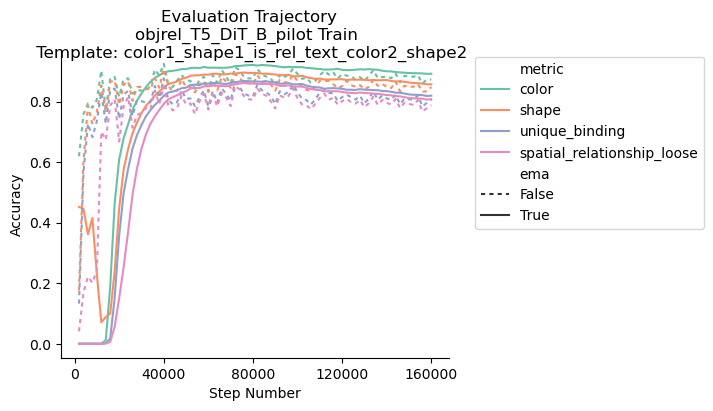

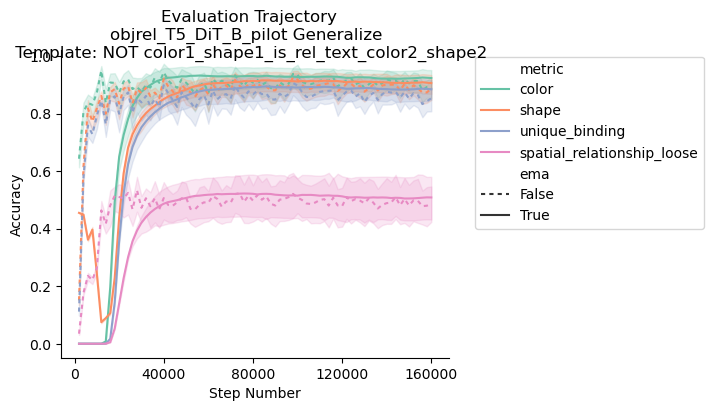

/tmp/ipykernel_3820371/1527341315.py:20: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_checkpoints_all_templates.csv"))


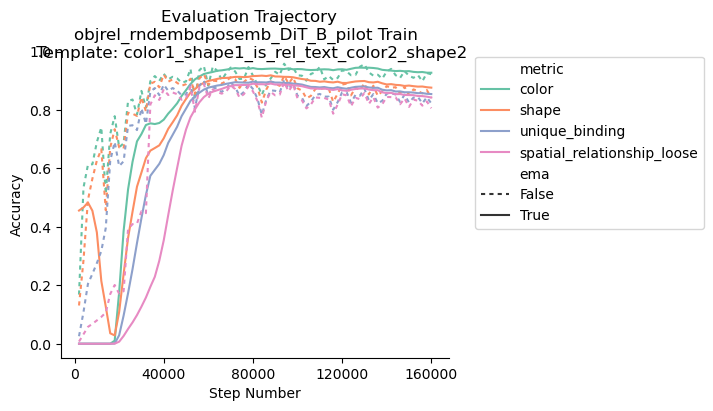

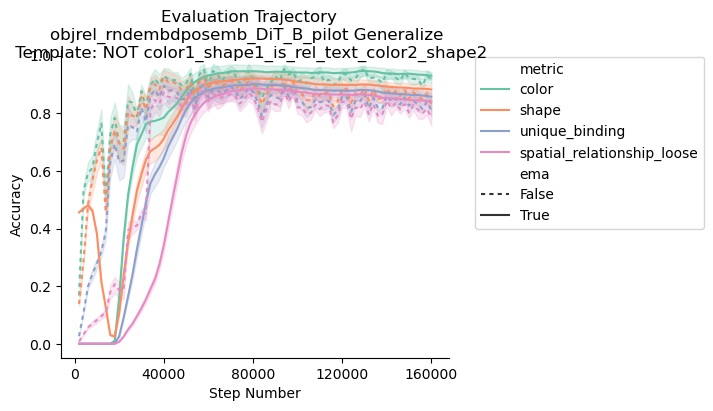

In [66]:
synopsis_dir = f"/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/model_eval_synopsis"
os.makedirs(synopsis_dir, exist_ok=True)
for model_run_name in [
                        "objrel_T5_DiT_B_pilot",
                        # "objrel_T5_DiT_mini_pilot", 
                        "objrel_rndembdposemb_DiT_B_pilot",
                        # "objrel_rndembdposemb_DiT_micro_pilot",
                        # "objrel_rndembdposemb_DiT_nano_pilot",
                        # "objrel_rndembdposemb_DiT_mini_pilot",
                        # "objrel_rndemb_DiT_B_pilot",
                        # "objrel_T5_DiT_B_pilot_WDecay",
                        # "objrel_T5_DiT_mini_pilot_WDecay"
                        ]:
    savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
    # figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
    # result_dir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}"
    eval_dir = join(savedir, "generalization_eval")
    
    # eval_df_all_temp = pd.read_csv(join(join(evaldir, f"eval_df_{ckpt_name}_ema_all_templates.csv")))
    eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_checkpoints_all_templates.csv"))
    # object_df_all_traj = pd.read_pickle(join(eval_dir, f"object_df_all_train_traj_prompts.pkl"))
    # eval_df_all_traj['spatial_relation_loose'] = evaluate_spatial_relation_loose_vectorized(eval_df_all_traj, threshold = 8)
    eval_df_all_traj_syn = eval_df_all_traj.groupby(["template", "step_num", "ema"]).mean(numeric_only=True).reset_index()
    # eval_df_all_traj_syn.droplevel
    # 1) melt into long form
    df_long = eval_df_all_traj_syn.reset_index().melt(
        id_vars=["template", "step_num", "ema"],
        # value_vars=["color", "shape", "exist_binding", "unique_binding", "spatial_relationship", "spatial_relationship_loose"],
        value_vars=["color", "shape", "unique_binding", "spatial_relationship_loose", ],
        var_name="metric",
        value_name="value",
    )
    # 2) make the combined label column
    df_long["legend_label"] = df_long["metric"]# + " " + df_long["ema"]
    # 3) plot, using legend_label for hue and metric for style (if you still want different markers/linestyles)
    template_name = "color1_shape1_is_rel_text_color2_shape2"
    plt.figure(figsize=(5, 4))
    sns.lineplot(
        data=df_long.query("template == @template_name"),
        x="step_num",
        y="value",
        hue="metric",
        style="ema",
        dashes={True: "", False: (2, 2)},  # solid for True, dashed for False
        palette="Set2",
        markers=False,    # or dashes=True
    )
    plt.xlabel("Step Number")
    plt.ylabel("Accuracy")
    # Get current tick locations and show every 4th tick for sparser display
    plt.xticks(range(0, 160001, 40000))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="")
    plt.suptitle(f"Evaluation Trajectory\n{model_run_name} Train \n Template: {template_name}")
    # saveallforms(eval_dir, "eval_train_dynamics_traj_syn")
    saveallforms(synopsis_dir, f"{model_run_name}_both_eval_train_dynamics_traj_syn_template_{template_name}")
    plt.show()
    
    template_name = "color1_shape1_is_rel_text_color2_shape2"
    plt.figure(figsize=(5, 4))
    sns.lineplot(
        data=df_long.query("template != @template_name"),
        x="step_num",
        y="value",
        hue="metric",
        style="ema",
        dashes={True: "", False: (2, 2)},  # solid for True, dashed for False
        palette="Set2",
        markers=False,    # or dashes=True
    )
    plt.xlabel("Step Number")
    plt.ylabel("Accuracy")
    # Get current tick locations and show every 4th tick for sparser display
    plt.xticks(range(0, 160001, 40000))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="")
    plt.suptitle(f"Evaluation Trajectory\n{model_run_name} Generalize \n Template: NOT {template_name}")
    # saveallforms(eval_dir, "eval_train_dynamics_traj_syn")
    saveallforms(synopsis_dir, f"{model_run_name}_both_eval_train_dynamics_traj_syn_template_generalization_others")
    plt.show()

In [59]:
df_long.head()

,template,step_num,ema,metric,value,legend_label
0,color1_shape1_is_rel_text_color2_shape2,2000,False,color,0.168213,color
1,color1_shape1_is_rel_text_color2_shape2,2000,True,color,0.000000,color
2,color1_shape1_is_rel_text_color2_shape2,4000,False,color,0.533936,color
3,color1_shape1_is_rel_text_color2_shape2,4000,True,color,0.000000,color
4,color1_shape1_is_rel_text_color2_shape2,6000,False,color,0.612245,color


/tmp/ipykernel_3820371/1496254155.py:20: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_checkpoints_all_templates.csv"))


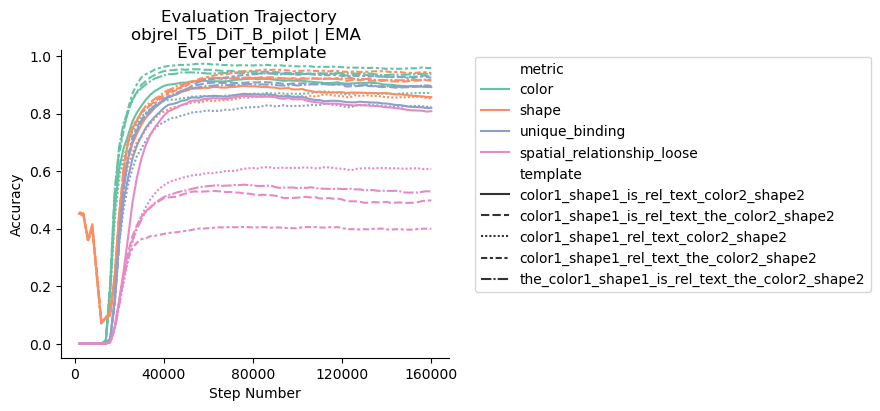

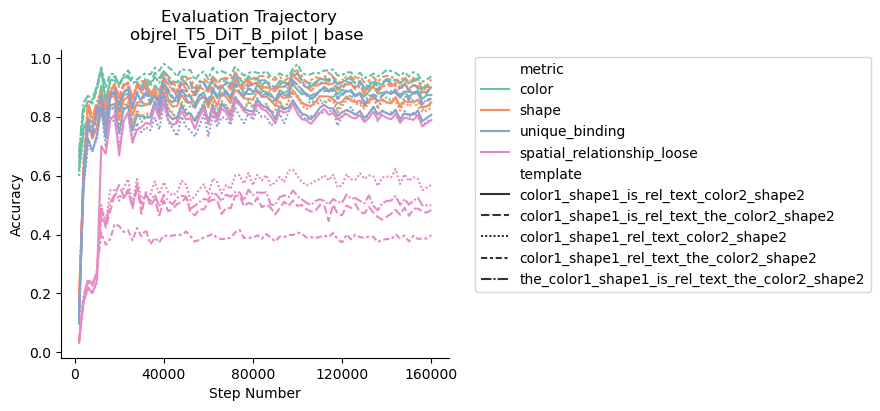

/tmp/ipykernel_3820371/1496254155.py:20: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_checkpoints_all_templates.csv"))


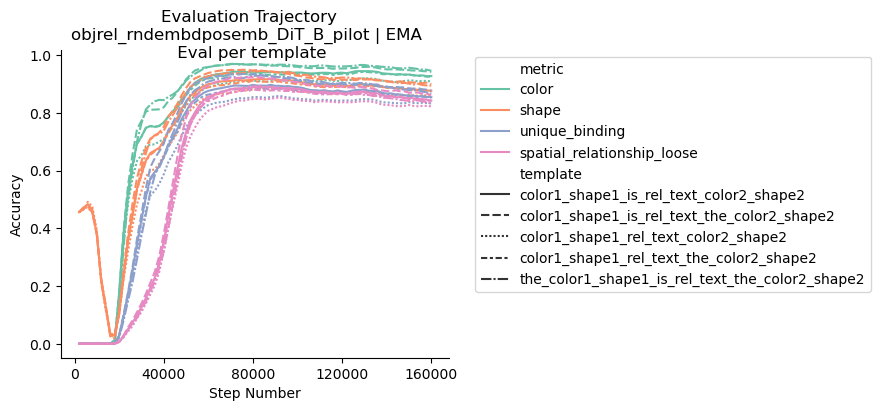

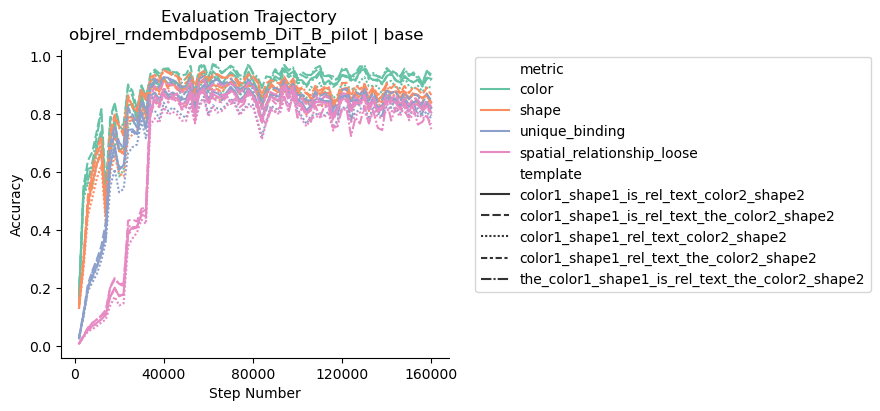

In [65]:
synopsis_dir = f"/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/model_eval_synopsis"
os.makedirs(synopsis_dir, exist_ok=True)
for model_run_name in [
                        "objrel_T5_DiT_B_pilot",
                        # "objrel_T5_DiT_mini_pilot", 
                        "objrel_rndembdposemb_DiT_B_pilot",
                        # "objrel_rndembdposemb_DiT_micro_pilot",
                        # "objrel_rndembdposemb_DiT_nano_pilot",
                        # "objrel_rndembdposemb_DiT_mini_pilot",
                        # "objrel_rndemb_DiT_B_pilot",
                        # "objrel_T5_DiT_B_pilot_WDecay",
                        # "objrel_T5_DiT_mini_pilot_WDecay"
                        ]:
    savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
    # figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
    # result_dir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}"
    eval_dir = join(savedir, "generalization_eval")
    
    # eval_df_all_temp = pd.read_csv(join(join(evaldir, f"eval_df_{ckpt_name}_ema_all_templates.csv")))
    eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_checkpoints_all_templates.csv"))
    # object_df_all_traj = pd.read_pickle(join(eval_dir, f"object_df_all_train_traj_prompts.pkl"))
    # eval_df_all_traj['spatial_relation_loose'] = evaluate_spatial_relation_loose_vectorized(eval_df_all_traj, threshold = 8)
    eval_df_all_traj_syn = eval_df_all_traj.groupby(["template", "step_num", "ema"]).mean(numeric_only=True).reset_index()
    # eval_df_all_traj_syn.droplevel
    # 1) melt into long form
    df_long = eval_df_all_traj_syn.reset_index().melt(
        id_vars=["template", "step_num", "ema"],
        # value_vars=["color", "shape", "exist_binding", "unique_binding", "spatial_relationship", "spatial_relationship_loose"],
        value_vars=["color", "shape", "unique_binding", "spatial_relationship_loose", ],
        var_name="metric",
        value_name="value",
    )
    # 2) make the combined label column
    df_long["legend_label"] = df_long["metric"]# + " " + df_long["ema"]
    # 3) plot, using legend_label for hue and metric for style (if you still want different markers/linestyles)
    plt.figure(figsize=(5, 4))
    sns.lineplot(
        data=df_long.query("ema"),
        x="step_num",
        y="value",
        hue="metric",
        style="template",
        palette="Set2",
        markers=False,    # or dashes=True
    )
    plt.xlabel("Step Number")
    plt.ylabel("Accuracy")
    # Get current tick locations and show every 4th tick for sparser display
    plt.xticks(range(0, 160001, 40000))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="")
    plt.suptitle(f"Evaluation Trajectory\n{model_run_name} | EMA \n Eval per template")
    # saveallforms(eval_dir, "eval_train_dynamics_traj_syn")
    saveallforms(synopsis_dir, f"{model_run_name}_EMA_eval_train_dynamics_traj_syn_per_template")
    plt.show()
    
    plt.figure(figsize=(5, 4))
    sns.lineplot(
        data=df_long.query("not ema"),
        x="step_num",
        y="value",
        hue="metric",
        style="template",
        palette="Set2",
        markers=False,    # or dashes=True
    )
    plt.xlabel("Step Number")
    plt.ylabel("Accuracy")
    # Get current tick locations and show every 4th tick for sparser display
    plt.xticks(range(0, 160001, 40000))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="")
    plt.suptitle(f"Evaluation Trajectory\n{model_run_name} | base \n Eval per template")
    # saveallforms(eval_dir, "eval_train_dynamics_traj_syn")
    saveallforms(synopsis_dir, f"{model_run_name}_BASE_eval_train_dynamics_traj_syn_per_template")
    plt.show()

In [50]:
eval_df_all_traj.columns

Index(['prompt_id', 'prompt', 'sample_id', 'overall', 'overall_loose', 'shape',
       'color', 'exist_binding', 'unique_binding', 'spatial_relationship',
       'spatial_relationship_loose', 'Dx', 'Dy', 'x1', 'y1', 'x2', 'y2',
       'checkpoint', 'step_num', 'ema', 'template', 'reason'],
      dtype='object')

In [52]:
eval_df_all_traj.shape

(10348800, 22)

In [51]:
eval_df_all_traj.template.unique()

array(['color1_shape1_is_rel_text_color2_shape2',
       'color1_shape1_rel_text_color2_shape2',
       'color1_shape1_rel_text_the_color2_shape2',
       'color1_shape1_is_rel_text_the_color2_shape2',
       'the_color1_shape1_is_rel_text_the_color2_shape2'], dtype=object)

In [46]:
eval_df_all_traj.head()

,prompt_id,prompt,sample_id,overall,overall_loose,shape,color,exist_binding,unique_binding,spatial_relationship,...,Dy,x1,y1,x2,y2,checkpoint,step_num,ema,template,reason
0,0,red square is to the upper left of blue triangle,0,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,epoch_50_step_2000.pth,2000,True,color1_shape1_is_rel_text_color2_shape2,NaN
1,0,red square is to the upper left of blue triangle,1,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,epoch_50_step_2000.pth,2000,True,color1_shape1_is_rel_text_color2_shape2,NaN
2,0,red square is to the upper left of blue triangle,2,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,epoch_50_step_2000.pth,2000,True,color1_shape1_is_rel_text_color2_shape2,NaN
3,0,red square is to the upper left of blue triangle,3,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,epoch_50_step_2000.pth,2000,True,color1_shape1_is_rel_text_color2_shape2,NaN
4,0,red square is to the upper left of blue triangle,4,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,epoch_50_step_2000.pth,2000,True,color1_shape1_is_rel_text_color2_shape2,NaN


### Deviation as function of relation

### Prompt specific evaluation

In [11]:
import pandas as pd
eval_df_all_temp = pd.read_csv(join(join(evaldir, "eval_df_epoch_2400_step_96000.pth_model_all_templates.csv")))
eval_df_all_temp.select_dtypes(include=['number', 'bool']).mean()

prompt_id                       131.500000
sample_id                        24.000000
overall                           0.395130
overall_loose                     0.571645
shape                             0.890213
color                             0.901422
exist_binding                     0.861673
unique_binding                    0.860838
spatial_relationship              0.395130
spatial_relationship_loose        0.571645
Dx                              -14.234110
Dy                              -22.365775
x1                               58.432838
y1                               52.098421
x2                               72.666948
y2                               74.464197
step_num                      96000.000000
ema                               0.000000
dtype: float64

In [5]:
!ls {evaldir}

eval_df_all_checkpoints_all_templates.csv
eval_df_epoch_1000_step_40000.pth_all_templates.csv
eval_df_epoch_1000_step_40000.pth_color1_shape1_is_rel_text_color2_shape2.csv
eval_df_epoch_1000_step_40000.pth_color1_shape1_rel_text_color2_shape2.csv
eval_df_epoch_1000_step_40000.pth_color1_shape1_rel_text_the_color2_shape2.csv
eval_df_epoch_1000_step_40000.pth_ema_all_templates.csv
eval_df_epoch_1000_step_40000.pth_ema_color1_shape1_is_rel_text_color2_shape2.csv
eval_df_epoch_1000_step_40000.pth_ema_color1_shape1_is_rel_text_the_color2_shape2.csv
eval_df_epoch_1000_step_40000.pth_ema_color1_shape1_rel_text_color2_shape2.csv
eval_df_epoch_1000_step_40000.pth_ema_color1_shape1_rel_text_the_color2_shape2.csv
eval_df_epoch_1000_step_40000.pth_ema_the_color1_shape1_is_rel_text_the_color2_shape2.csv
eval_df_epoch_1000_step_40000.pth_model_all_templates.csv
eval_df_epoch_1000_step_40000.pth_model_color1_shape1_is_rel_text_color2_shape2.csv
eval_df_epoch_1000_step_40000.pth_model_color1_shape1_is

In [ ]:
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
# savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"
config = read_config(join(savedir, 'config.py'))
# Build pipeline from config
pipeline = construct_diffuser_pipeline_from_config(config, pipeline_class=PixArtAlphaPipeline_custom)

weight_dtype: torch.float16


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.


### Scratch

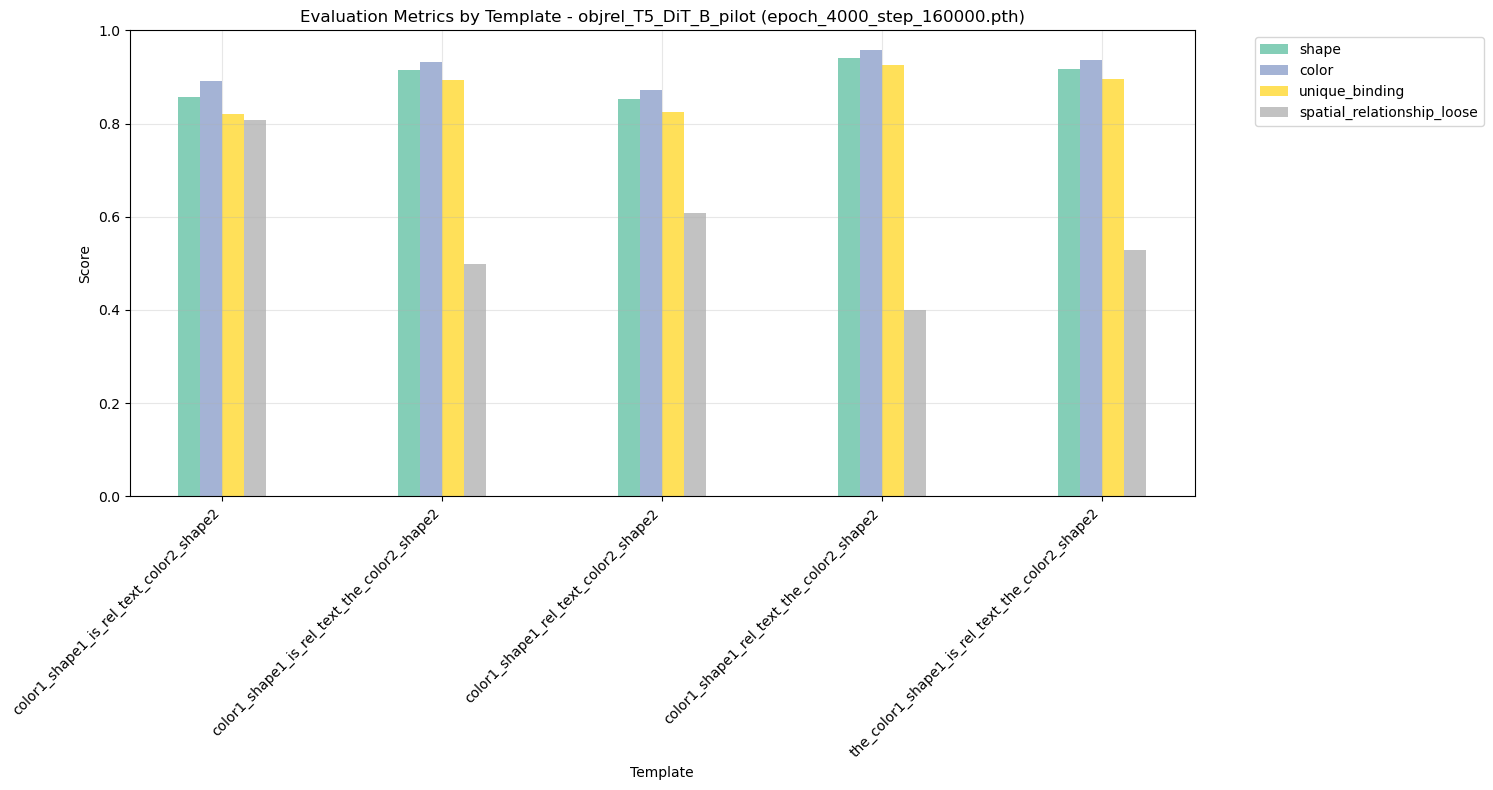

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the grouped data by template
template_means = eval_df_all_temp.groupby("template").mean(numeric_only=True)

# Select the key evaluation metrics to plot
# metrics_to_plot = ['overall', 'overall_loose', 'shape', 'color', 'exist_binding', 
#                    'unique_binding', 'spatial_relationship', 'spatial_relationship_loose']
metrics_to_plot = ['shape', 'color', 'unique_binding', 'spatial_relationship_loose']

# Create the bar plot
fig, ax = plt.subplots(figsize=(15, 8))

# Number of templates and metrics
n_templates = len(template_means.index)
n_metrics = len(metrics_to_plot)

# Set up bar positions
x = np.arange(n_templates)
width = 0.1  # Width of each bar
colors = plt.cm.Set2(np.linspace(0, 1, n_metrics))  # Different colors for each metric

# Plot bars for each metric
for i, metric in enumerate(metrics_to_plot):
    if metric in template_means.columns:
        offset = (i - n_metrics/2 + 0.5) * width
        bars = ax.bar(x + offset, template_means[metric], width, 
                     label=metric, color=colors[i], alpha=0.8)

# Customize the plot
ax.set_xlabel('Template')
ax.set_ylabel('Score')
ax.set_title(f'Evaluation Metrics by Template - {model_run_name} ({ckpt_name})')
ax.set_xticks(x)
ax.set_xticklabels(template_means.index, rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.0)
plt.tight_layout()
plt.show()